In [1]:
# ─── 1. Environment Setup and Imports ────────────────────────────────────────
import os
import fitz               
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import csv
import json
from datetime import datetime
from agentic_doc.parse import parse_documents
from transformers import pipeline

# (Re-declare your existing env vars if you still need them elsewhere)
os.environ['VISION_AGENT_API_KEY']    = 'cTBodDlyaGgyOGlxdGFya2Y4OWdiOmg5dm54aUhoVWdzQk1wc1IwQkVwYjBGcnp3Mkh0NUF6'
os.environ['BATCH_SIZE']              = '2'
os.environ['MAX_WORKERS']             = '4'
os.environ['MAX_RETRIES']             = '80'
os.environ['MAX_RETRY_WAIT_TIME']     = '30'
os.environ['RETRY_LOGGING_STYLE']     = 'log_msg'

print("KEY:", repr(os.environ.get('VISION_AGENT_API_KEY')))
print("BATCH_SIZE:", os.environ.get('BATCH_SIZE'))


2025-04-26 19:01:28 [info   ] Settings loaded: {
  "vision_agent_api_key": "[REDACTED]",
  "batch_size": 4,
  "max_workers": 5,
  "max_retries": 100,
  "max_retry_wait_time": 60,
  "retry_logging_style": "log_msg",
  "pdf_to_image_dpi": 96
} [agentic_doc.config] (config.py:80)
KEY: 'cTBodDlyaGgyOGlxdGFya2Y4OWdiOmg5dm54aUhoVWdzQk1wc1IwQkVwYjBGcnp3Mkh0NUF6'
BATCH_SIZE: 2


Displaying first page of: data\K7\K 7 Power Flex Home _ Kärcher.pdf


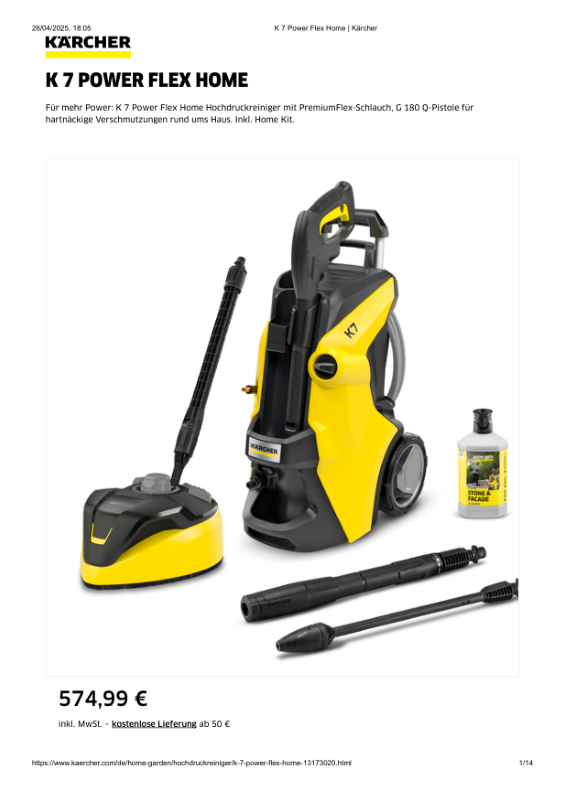

In [2]:
# 1) Find the first PDF in data/K2
k7_dir = os.path.join("data", "K7")
pdfs = sorted(f for f in os.listdir(k7_dir) if f.lower().endswith(".pdf"))
if not pdfs:
    raise FileNotFoundError(f"No PDFs found in {k7_dir}")
pdf_path = os.path.join(k7_dir, pdfs[0])
print(f"Displaying first page of: {pdf_path}")

# 2) Load PDF and render page to pixel map
doc = fitz.open(pdf_path)
page = doc.load_page(0)                     
pix = page.get_pixmap(alpha=False)           

# 3) Convert to NumPy array (H×W×C)
img = np.frombuffer(pix.samples, dtype=np.uint8)
img = img.reshape(pix.height, pix.width, pix.n)  

# 4) Display with Matplotlib
plt.figure(figsize=(13, 10))
plt.imshow(img)
plt.axis("off")
plt.show()


In [3]:
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 1,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

NameError: name 'text_formatter' is not defined

In [ ]:
import random

random.sample(pages_and_texts, k=3)

In [ ]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

In [ ]:
df.describe().round(2)

In [ ]:
# ─── 2. ModernBERT Embedder (UNCHANGED) ─────────────────────────────────────
embedder = pipeline(
    model="answerdotai/ModernBERT-base",      # model used for embedding
    tokenizer="answerdotai/ModernBERT-base",  # tokenizer used for embedding
    task="feature-extraction",                # feature extraction task
    device=0                                   # use GPU 0 if available
)

def get_embeddings(data):
    """ Extract the [CLS] embedding for each text. """
    embeddings = embedder(data["text"])             # Full token embeddings
    cls_embeddings = [e[0][0] for e in embeddings]  # Extract first token ([CLS])
    return {"embeddings": cls_embeddings}


In [4]:
# ─── 3.′ Batch-Process → Chunking → Embedding → CSV ─────────────────────────
def process_pdf_and_embed_chunks(pdf_path: str, embeddings_file: str, chunk_size: int = 10):
    """
    Parse a PDF, split into sentence-chunks of size `chunk_size`, embed each chunk,
    and append one CSV row per chunk.
    """
    # 1) Parse PDF
    results    = parse_documents([pdf_path])
    parsed_doc = results[0]

    # 2) Re-assemble page texts
    from collections import defaultdict
    pages = defaultdict(list)
    for chunk in parsed_doc.chunks:
        pages[chunk.page_number].append(chunk.content)

    # 3) Sentence-split & chunk each page (German)
    import re
    from spacy.lang.de import German
    nlp = German()
    nlp.add_pipe("sentencizer")

    timestamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    rows = []

    for page_num, texts in pages.items():
        full_text = " ".join(texts)
        doc       = nlp(full_text)
        sents     = [str(s).strip() for s in doc.sents]

        # group into fixed-size chunks
        for idx in range(0, len(sents), chunk_size):
            chunk_sents = sents[idx:idx + chunk_size]
            joined      = " ".join(chunk_sents)
            joined      = re.sub(r'\.([A-Z])', r'. \1', joined)

            rows.append({
                "page": page_num,
                "chunk_idx": idx // chunk_size,
                "text": joined
            })

    if not rows:
        print(f"No text found in {pdf_path}; skipping.")
        return

    # 4) Embed all chunks in one shot
    texts      = [r["text"] for r in rows]
    embeddings = get_embeddings({"text": texts})["embeddings"]

    # 5) Append to CSV
    import os, csv, json
    is_new = not os.path.isfile(embeddings_file)
    with open(embeddings_file, "a", newline="", encoding="utf-8") as csvf:
        writer = csv.writer(csvf)
        if is_new:
            writer.writerow([
                "file_name", "page_number", "chunk_index",
                "timestamp", "chunk_text", "embedding"
            ])
        base_name = os.path.splitext(os.path.basename(pdf_path))[0]
        for r, emb in zip(rows, embeddings):
            writer.writerow([
                base_name, r["page"], r["chunk_idx"],
                timestamp, r["text"], json.dumps(emb)
            ])

    print(f"→ Embedded {len(rows)} chunks from {base_name}")


def main():
    base          = "data"
    subfolders    = ["K2", "K3", "K4", "K5", "K7"]
    embeddings_csv = os.path.join(base, "agentic_extract", "embeddings_chunks.csv")
    os.makedirs(os.path.dirname(embeddings_csv), exist_ok=True)

    # Safely gather all PDFs, skipping missing dirs
    all_pdfs = []
    for sub in subfolders:
        dir_path = os.path.join(base, sub)
        if not os.path.isdir(dir_path):
            print(f"Warning: directory {dir_path!r} not found, skipping.")
            continue
        for fn in os.listdir(dir_path):
            if fn.lower().endswith(".pdf"):
                all_pdfs.append(os.path.join(dir_path, fn))

    if not all_pdfs:
        print("No PDFs found in any of the configured subfolders. Exiting.")
        return

    # Build set of already-processed file names
    processed = set()
    if os.path.isfile(embeddings_csv):
        with open(embeddings_csv, encoding="utf-8") as csvf:
            next(csvf)  # skip header
            for line in csvf:
                processed.add(line.split(",")[0])

    # Filter down to only new PDFs
    to_proc = [
        p for p in all_pdfs
        if os.path.splitext(os.path.basename(p))[0] not in processed
    ]

    if not to_proc:
        print("All found PDFs have already been chunk-embedded. Nothing to do.")
        return

    print(f"Processing {len(to_proc)} PDFs → chunk → embed → CSV…")
    for pdf in to_proc:
        try:
            process_pdf_and_embed_chunks(pdf, embeddings_csv, chunk_size=10)
        except Exception as e:
            print(f"Error on {pdf}: {e}")


if __name__ == "__main__":
    main()

Processing 15 PDFs → chunk → embed → CSV…
2025-04-26 19:02:27 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:27 [info   ] Splitting PDF: 'data\K7\K 7 Power Flex Home _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmpt5cbb2xu' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:27 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpt5cbb2xu\K 7 Power Flex Home _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:27 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpt5cbb2xu\K 7 Power Flex Home _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:27 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpt5cbb2xu\K 7 Power Flex Home _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:27 [info   ] Start parsing document part: 'File name: K 7 Power Flex Home _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:234)


2025-04-26 19:02:27 [info   ] 

Parsing document parts from 'K 7 Power Flex Home _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

Start parsing document part: 'File name: K 7 Power Flex Home _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:27 [info   ] Start parsing document part: 'File name: K 7 Power Flex Home _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:28 [error  ] Error parsing document 'File name: K 7 Power Flex Home _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:28 [

error  ] 

Parsing document parts from 'K 7 Power Flex Home _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:01,  1.96it/s]

Error parsing document 'File name: K 7 Power Flex Home _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:28 [error  ] Error parsing document 'File name: K 7 Power Flex Home _ Kärcher_3.pdf	Page: [4:4]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 Power Flex Home _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Error on data\K7\K 7 Power Flex Home _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:28 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:28 [info   ] Splitting PDF: 'data\K7\K 7 Power Flex _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmpi543igau' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:28 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpi543igau\K 7 Power Flex _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:28 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpi543igau\K 7 Power Flex _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:28 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpi543igau\K 7 Power Flex _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:28 [info   ] Start parsing document part: 'File name: K 7 Power Flex _ Kärcher_1.pdf	Page: [0:1]' [

agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:28

Parsing document parts from 'K 7 Power Flex _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

 [info   ] Start parsing document part: 'File name: K 7 Power Flex _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:28 [info   ] Start parsing document part: 'File name: K 7 Power Flex _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:28 [error  ] Error parsing document 'File name: K 7 Power Flex _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


2025-04-26 19:02:28 [error  ] 

Parsing document parts from 'K 7 Power Flex _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  3.85it/s]

Error parsing document 'File name: K 7 Power Flex _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:28 [error  ] Error parsing document 'File name: K 7 Power Flex _ Kärcher_3.pdf	Page: [4:4]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 Power Flex _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00, 10.68it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Error on data\K7\K 7 Power Flex _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:28 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:28 [info   ] Splitting PDF: 'data\K7\K 7 Premium Power Flex Home _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmpnypiwfk7' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:29 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpnypiwfk7\K 7 Premium Power Flex Home _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:29 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpnypiwfk7\K 7 Premium Power Flex Home _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:29 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpnypiwfk7\K 7 Premium Power Flex Home _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:29 [info   ] Start parsing document part: 'File name: K 7 Premium Power Flex Home _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:29 [info   

] Start parsing document part: 'File name: K 7 Premium Power Flex Home _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse

Parsing document parts from 'K 7 Premium Power Flex Home _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

] (parse.py:234)
2025-04-26 19:02:29 [info   ] Start parsing document part: 'File name: K 7 Premium Power Flex Home _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:29 [error  ] Error parsing document 'File name: K 7 Premium Power Flex Home _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)



Parsing document parts from 'K 7 Premium Power Flex Home _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  4.19it/s]

2025-04-26 19:02:29 [error  ] Error parsing document 'File name: K 7 Premium Power Flex Home _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:29 [error  ] Error parsing document 'File name: K 7 Premium Power Flex Home _ Kärcher_3.pdf	Page: [4:4]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 Premium Power Flex Home _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00, 10.89it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Error on data\K7\K 7 Premium Power Flex Home _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:29 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:29 [info   ] Splitting PDF: 'data\K7\K 7 Premium Power Flex _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmpvkymb8vq' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:29 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpvkymb8vq\K 7 Premium Power Flex _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:29 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpvkymb8vq\K 7 Premium Power Flex _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:29 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpvkymb8vq\K 7 Premium Power Flex _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:29 [info   ] Start parsing document part: 'File name: K 7 Premium Power Flex _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:29 [info   ] Start parsing document part: 'File name: K 7 Premium Power Flex _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:234)



Parsing document parts from 'K 7 Premium Power Flex _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-26 19:02:29 [info   ] Start parsing document part: 'File name: K 7 Premium Power Flex _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:29 [error  ] Error parsing document 'File name: K 7 Premium Power Flex _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)



Parsing document parts from 'K 7 Premium Power Flex _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  4.15it/s]

2025-04-26 19:02:29 [error  ] Error parsing document 'File name: K 7 Premium Power Flex _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:30 [error  ] Error parsing document 'File name: K 7 Premium Power Flex _ Kärcher_3.pdf	Page: [4:4]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 Premium Power Flex _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00,  9.54it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Error on data\K7\K 7 Premium Power Flex _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:30 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:30 [info   ] Splitting PDF: 'data\K7\K 7 Premium Smart Control Flex eco!B _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmpwesxwfr5' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:30 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpwesxwfr5\K 7 Premium Smart Control Flex eco!B _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:30 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpwesxwfr5\K 7 Premium Smart Control Flex eco!B _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:30 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpwesxwfr5\K 7 Premium Smart Control Flex eco!B _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:30 [info   ] Start parsing document part: 'File name: K 7 Premium Smart Control Flex eco!B _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:234)


2025-04-26 19:02:30 [info   

Parsing document parts from 'K 7 Premium Smart Control Flex eco!B _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

] Start parsing document part: 'File name: K 7 Premium Smart Control Flex eco!B _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:30 [info   ] Start parsing document part: 'File name: K 7 Premium Smart Control Flex eco!B _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:30 [error  ] Error parsing document 'File name: K 7 Premium Smart Control Flex eco!B _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)



Parsing document parts from 'K 7 Premium Smart Control Flex eco!B _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  4.60it/s]

2025-04-26 19:02:30 [error  ] Error parsing document 'File name: K 7 Premium Smart Control Flex eco!B _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:30 [error  ] Error parsing document 'File name: K 7 Premium Smart Control Flex eco!B _ Kärcher_3.pdf	Page: [4:4]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 Premium Smart Control Flex eco!B _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00, 10.12it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Error on data\K7\K 7 Premium Smart Control Flex eco!B _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:30 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:30 [info   ] Splitting PDF: 'data\K7\K 7 Premium Smart Control Flex Home _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmpkkcndpkk' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:30 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpkkcndpkk\K 7 Premium Smart Control Flex Home _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:31 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpkkcndpkk\K 7 Premium Smart Control Flex Home _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:31 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpkkcndpkk\K 7 Premium Smart Control Flex Home _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:31 [info   ] Start parsing document part: 'File name: K 7 Premium Smart Control Flex Home _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:31 [info   ] Start parsing document part: 'File name: K 7 Premium Smart Control 

] Start parsing document part: 'File name: K 7 Premium Smart Control Flex Home _ Kärcher_3.pdf	Page: [4:4]'

Parsing document parts from 'K 7 Premium Smart Control Flex Home _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

 [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:31 [error  ] Error parsing document 'File name: K 7 Premium Smart Control Flex Home _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)



Parsing document parts from 'K 7 Premium Smart Control Flex Home _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  4.77it/s]

2025-04-26 19:02:31 [error  ] Error parsing document 'File name: K 7 Premium Smart Control Flex Home _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:31 [error  ] Error parsing document 'File name: K 7 Premium Smart Control Flex Home _ Kärcher_3.pdf	Page: [4:4]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 Premium Smart Control Flex Home _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00, 10.77it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Error on data\K7\K 7 Premium Smart Control Flex Home _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:31 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:31 [info   ] Splitting PDF: 'data\K7\K 7 Premium Smart Control Flex _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmpq6r0onuh' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:31 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpq6r0onuh\K 7 Premium Smart Control Flex _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:31 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpq6r0onuh\K 7 Premium Smart Control Flex _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:31 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpq6r0onuh\K 7 Premium Smart Control Flex _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:31 [info   ] Start parsing document part: 'File name: K 7 Premium Smart Control Flex _ Kärcher_1.pdf	Page: [0:1]' [

agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:31

Parsing document parts from 'K 7 Premium Smart Control Flex _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

 [info   ] Start parsing document part: 'File name: K 7 Premium Smart Control Flex _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:31 [info   ] Start parsing document part: 'File name: K 7 Premium Smart Control Flex _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:32 [error  ] Error parsing document 'File name: K 7 Premium Smart Control Flex _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)



Parsing document parts from 'K 7 Premium Smart Control Flex _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  3.68it/s]

2025-04-26 19:02:32 [error  ] Error parsing document 'File name: K 7 Premium Smart Control Flex _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:32 [error  ] Error parsing document 'File name: K 7 Premium Smart Control Flex _ Kärcher_3.pdf	Page: [4:4]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 Premium Smart Control Flex _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00,  9.91it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Error on data\K7\K 7 Premium Smart Control Flex _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:32 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:32 [info   ] Splitting PDF: 'data\K7\K 7 Smart Control Flex eco!Booster _ Kärcher.pdf' into 3 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmpgbb5f7ie' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:32 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpgbb5f7ie\K 7 Smart Control Flex eco!Booster _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:32 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpgbb5f7ie\K 7 Smart Control Flex eco!Booster _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:32 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpgbb5f7ie\K 7 Smart Control Flex eco!Booster _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:32 [info   ] Start parsing document part: 'File name: K 7 Smart Control Flex eco!Booster _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:32 [info   ] Start parsing document part: 'File name: K 7 Smart Control Flex eco!Boos

agentic_doc.parse]

Parsing document parts from 'K 7 Smart Control Flex eco!Booster _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

 (parse.py:234)
2025-04-26 19:02:32 [info   ] Start parsing document part: 'File name: K 7 Smart Control Flex eco!Booster _ Kärcher_3.pdf	Page: [4:5]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:32 [error  ] Error parsing document 'File name: K 7 Smart Control Flex eco!Booster _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)



Parsing document parts from 'K 7 Smart Control Flex eco!Booster _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  4.07it/s]

2025-04-26 19:02:32 [error  ] Error parsing document 'File name: K 7 Smart Control Flex eco!Booster _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:32 [error  ] Error parsing document 'File name: K 7 Smart Control Flex eco!Booster _ Kärcher_3.pdf	Page: [4:5]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 Smart Control Flex eco!Booster _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00, 10.22it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Error on data\K7\K 7 Smart Control Flex eco!Booster _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:32 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:32 [info   ] Splitting PDF: 'data\K7\K 7 Smart Control Flex Home _ Kärcher.pdf' into 3 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmp6zxohrkt' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:33 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp6zxohrkt\K 7 Smart Control Flex Home _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:33 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp6zxohrkt\K 7 Smart Control Flex Home _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:33 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp6zxohrkt\K 7 Smart Control Flex Home _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:33 [info   ] Start parsing document part: 'File name: K 7 Smart Control Flex Home _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse

] (parse.py:234)


Parsing document parts from 'K 7 Smart Control Flex Home _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-26 19:02:33 [info   ] Start parsing document part: 'File name: K 7 Smart Control Flex Home _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:33 [info   ] Start parsing document part: 'File name: K 7 Smart Control Flex Home _ Kärcher_3.pdf	Page: [4:5]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:33 [error  ] Error parsing document 'File name: K 7 Smart Control Flex Home _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


2025-04-26 19:02:33 [error  

Parsing document parts from 'K 7 Smart Control Flex Home _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  3.67it/s]

] Error parsing document 'File name: K 7 Smart Control Flex Home _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:33 [error  ] Error parsing document 'File name: K 7 Smart Control Flex Home _ Kärcher_3.pdf	Page: [4:5]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)



Parsing document parts from 'K 7 Smart Control Flex Home _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00,  7.53it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Error on data\K7\K 7 Smart Control Flex Home _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:33 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:33 [info   ] Splitting PDF: 'data\K7\K 7 Smart Control Flex _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmph7rt2txz' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:33 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmph7rt2txz\K 7 Smart Control Flex _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:33 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmph7rt2txz\K 7 Smart Control Flex _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:33 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmph7rt2txz\K 7 Smart Control Flex _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:33 [info   ] Start parsing document part: 'File name: K 7 Smart Control Flex _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:33 [info   ] Start parsing document part: 'File name: K 7 Smart Control Flex _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:234)
2025

] Start parsing document part: 'File name: K 7 Smart Control Flex _ Kärcher_3.pdf	Page: [4:4]' [

Parsing document parts from 'K 7 Smart Control Flex _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:34 [error  ] Error parsing document 'File name: K 7 Smart Control Flex _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)



Parsing document parts from 'K 7 Smart Control Flex _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  4.44it/s]

2025-04-26 19:02:34 [error  ] Error parsing document 'File name: K 7 Smart Control Flex _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:34 [error  ] Error parsing document 'File name: K 7 Smart Control Flex _ Kärcher_3.pdf	Page: [4:4]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 Smart Control Flex _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00, 10.12it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Error on data\K7\K 7 Smart Control Flex _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:34 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:34 [info   ] Splitting PDF: 'data\K7\K 7 WCM Car&Home _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmpjaadmpv1' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:34 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpjaadmpv1\K 7 WCM Car&Home _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:34 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpjaadmpv1\K 7 WCM Car&Home _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:34 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpjaadmpv1\K 7 WCM Car&Home _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:34 [info   ] Start parsing document part: 'File name: K 7 WCM Car&Home _ Kärcher_1.pdf	Page: [0:1]' [

agentic_doc.parse]

Parsing document parts from 'K 7 WCM Car&Home _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

 (parse.py:234)
2025-04-26 19:02:34 [info   ] Start parsing document part: 'File name: K 7 WCM Car&Home _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:34 [info   ] Start parsing document part: 'File name: K 7 WCM Car&Home _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:34 [error  ] Error parsing document 'File name: K 7 WCM Car&Home _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:34 [error  

] Error parsing document 'File name: K 7 WCM Car&Home _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:34

Parsing document parts from 'K 7 WCM Car&Home _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  3.56it/s]

 [error  ] Error parsing document 'File name: K 7 WCM Car&Home _ Kärcher_3.pdf	Page: [4:4]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 WCM Car&Home _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00,  9.52it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Error on data\K7\K 7 WCM Car&Home _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:34 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:34 [info   ] Splitting PDF: 'data\K7\K 7 WCM FJ _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmp6mu3ef3w' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:35 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp6mu3ef3w\K 7 WCM FJ _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:35 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp6mu3ef3w\K 7 WCM FJ _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:35 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp6mu3ef3w\K 7 WCM FJ _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:35 [info   ] Start parsing document part: 'File name: K 7 WCM FJ _ Kärcher_1.pdf	Page: [0:1]'

 [agentic_doc.parse]

Parsing document parts from 'K 7 WCM FJ _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

 (parse.py:234)
2025-04-26 19:02:35 [info   ] Start parsing document part: 'File name: K 7 WCM FJ _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:35 [info   ] Start parsing document part: 'File name: K 7 WCM FJ _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:35 [error  ] Error parsing document 'File name: K 7 WCM FJ _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)



Parsing document parts from 'K 7 WCM FJ _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  3.29it/s]

2025-04-26 19:02:35 [error  ] Error parsing document 'File name: K 7 WCM FJ _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:35 [error  ] Error parsing document 'File name: K 7 WCM FJ _ Kärcher_3.pdf	Page: [4:4]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 WCM FJ _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00,  8.71it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Error on data\K7\K 7 WCM FJ _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:35 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:35 [info   ] Splitting PDF: 'data\K7\K 7 WCM Premium Home _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmp7vfk9hlg' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:35 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp7vfk9hlg\K 7 WCM Premium Home _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:35 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp7vfk9hlg\K 7 WCM Premium Home _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:35 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmp7vfk9hlg\K 7 WCM Premium Home _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:35 [info   ] Start parsing document part: 'File name: K 7 WCM Premium Home _ Kärcher_1.pdf	Page: [0:1]' [

agentic_doc.parse] (parse.py:234)


Parsing document parts from 'K 7 WCM Premium Home _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-26 19:02:35 [info   ] Start parsing document part: 'File name: K 7 WCM Premium Home _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:35 [info   ] Start parsing document part: 'File name: K 7 WCM Premium Home _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:36 [error  ] Error parsing document 'File name: K 7 WCM Premium Home _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)



Parsing document parts from 'K 7 WCM Premium Home _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  3.51it/s]

2025-04-26 19:02:36 [error  ] Error parsing document 'File name: K 7 WCM Premium Home _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:36 [error  ] Error parsing document 'File name: K 7 WCM Premium Home _ Kärcher_3.pdf	Page: [4:4]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 WCM Premium Home _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00,  9.18it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Error on data\K7\K 7 WCM Premium Home _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:36 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:36 [info   ] Splitting PDF: 'data\K7\K 7 WCM Premium _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmpc6l5newt' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:36 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpc6l5newt\K 7 WCM Premium _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:36 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpc6l5newt\K 7 WCM Premium _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:36 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpc6l5newt\K 7 WCM Premium _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:36 [info   ] Start parsing document part: 'File name: K 7 WCM Premium _ Kärcher_1.pdf	Page: [0:1]' [

agentic_doc.parse] (parse.py:234)


Parsing document parts from 'K 7 WCM Premium _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-26 19:02:36 [info   ] Start parsing document part: 'File name: K 7 WCM Premium _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:36 [info   ] Start parsing document part: 'File name: K 7 WCM Premium _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:36 [error  ] Error parsing document 'File name: K 7 WCM Premium _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:36 [error  ] Error parsing document 'File name: K 7 WCM Premium _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)



Parsing document parts from 'K 7 WCM Premium _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  3.18it/s]

2025-04-26 19:02:36 [error  ] Error parsing document 'File name: K 7 WCM Premium _ Kärcher_3.pdf	Page: [4:4]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 WCM Premium _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00,  8.39it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Error on data\K7\K 7 WCM Premium _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
2025-04-26 19:02:36 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:51)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-26 19:02:36 [info   ] Splitting PDF: 'data\K7\K 7 WCM _ Kärcher.pdf' into 2 parts under 'C:\Users\ALEXAN~1\AppData\Local\Temp\tmpwn5txu8i' [agentic_doc.utils] (utils.py:190)
2025-04-26 19:02:37 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpwn5txu8i\K 7 WCM _ Kärcher_1.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:37 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpwn5txu8i\K 7 WCM _ Kärcher_2.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:37 [info   ] Created C:\Users\ALEXAN~1\AppData\Local\Temp\tmpwn5txu8i\K 7 WCM _ Kärcher_3.pdf [agentic_doc.utils] (utils.py:206)
2025-04-26 19:02:37 [info   ] Start parsing document part: 'File name: K 7 WCM _ Kärcher_1.pdf	Page: [0:1]' [agentic_doc.parse] (parse.py:234)


2025-04-26 19:02:37 [info   

Parsing document parts from 'K 7 WCM _ Kärcher.pdf':   0%|          | 0/3 [00:00<?, ?it/s]

] Start parsing document part: 'File name: K 7 WCM _ Kärcher_2.pdf	Page: [2:3]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:37 [info   ] Start parsing document part: 'File name: K 7 WCM _ Kärcher_3.pdf	Page: [4:4]' [agentic_doc.parse] (parse.py:234)
2025-04-26 19:02:37 [error  ] Error parsing document 'File name: K 7 WCM _ Kärcher_1.pdf	Page: [0:1]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:37

 [error  ] 

Parsing document parts from 'K 7 WCM _ Kärcher.pdf':  33%|███▎      | 1/3 [00:00<00:00,  3.55it/s]

Error parsing document 'File name: K 7 WCM _ Kärcher_2.pdf	Page: [2:3]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)
2025-04-26 19:02:37 [error  ] Error parsing document 'File name: K 7 WCM _ Kärcher_3.pdf	Page: [4:4]' due to: Illegal header value b'Basic ' [agentic_doc.parse] (parse.py:247)


Parsing document parts from 'K 7 WCM _ Kärcher.pdf': 100%|██████████| 3/3 [00:00<00:00,  9.01it/s]
Parsing documents: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Error on data\K7\K 7 WCM _ Kärcher.pdf: 'Chunk' object has no attribute 'page_number'
